<a href="https://colab.research.google.com/github/Arindam75/graph_networks/blob/main/01_random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A bsic implementation of Deepwalk using two key components
- Random Walk
- Word2vec

In [ ]:
!pip install -qU gensim

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
random.seed(0)

In [ ]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


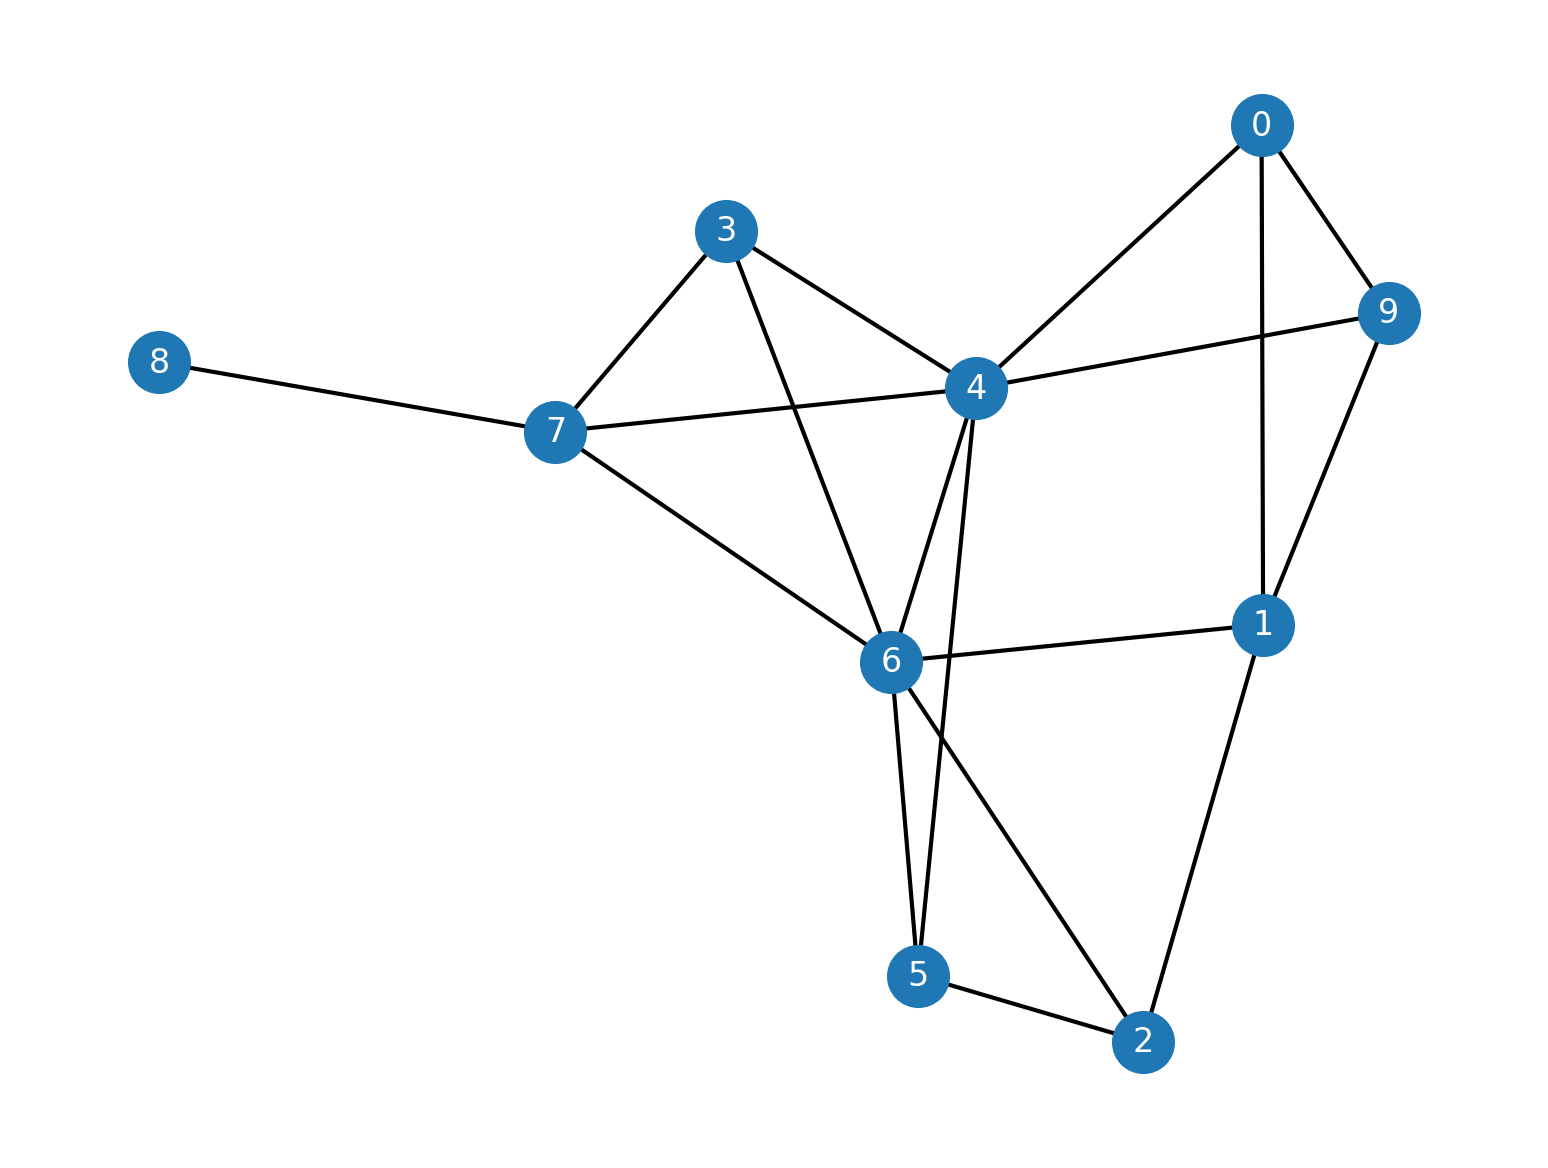

In [ ]:
plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                node_size=200,
                cmap='coolwarm',
                font_size=8,
                font_color='white'
                )

In [ ]:
nxt_node , start = 0, 0
walk = [start]
length = 20

for step in range(length):
  neighbors = [node for node in G.neighbors(nxt_node)]
  neighbors
  nxt_node = np.random.choice(neighbors, 1)[0]
  walk.append(nxt_node)

In [ ]:
walk

[0, 1, 2, 6, 5, 6, 1, 6, 1, 6, 3, 7, 6, 5, 4, 3, 7, 6, 1, 6, 7]

### Implementing Deepwalk

Our objective is to , eventually classify the nodes in this toy graph. These are the steps

- Build a toy graph
- Binary Encode the node labels
- Simulate 80 Random walks of length 10, starting from each node. This will build a dataset
- Use word2vec to generate embeddings for each node

In [ ]:
G = nx.karate_club_graph()

In [ ]:
labels = []
for node in G.nodes:

  label = G.nodes[node]['club']
  labels.append(1 if label == 'Officer' else 0)

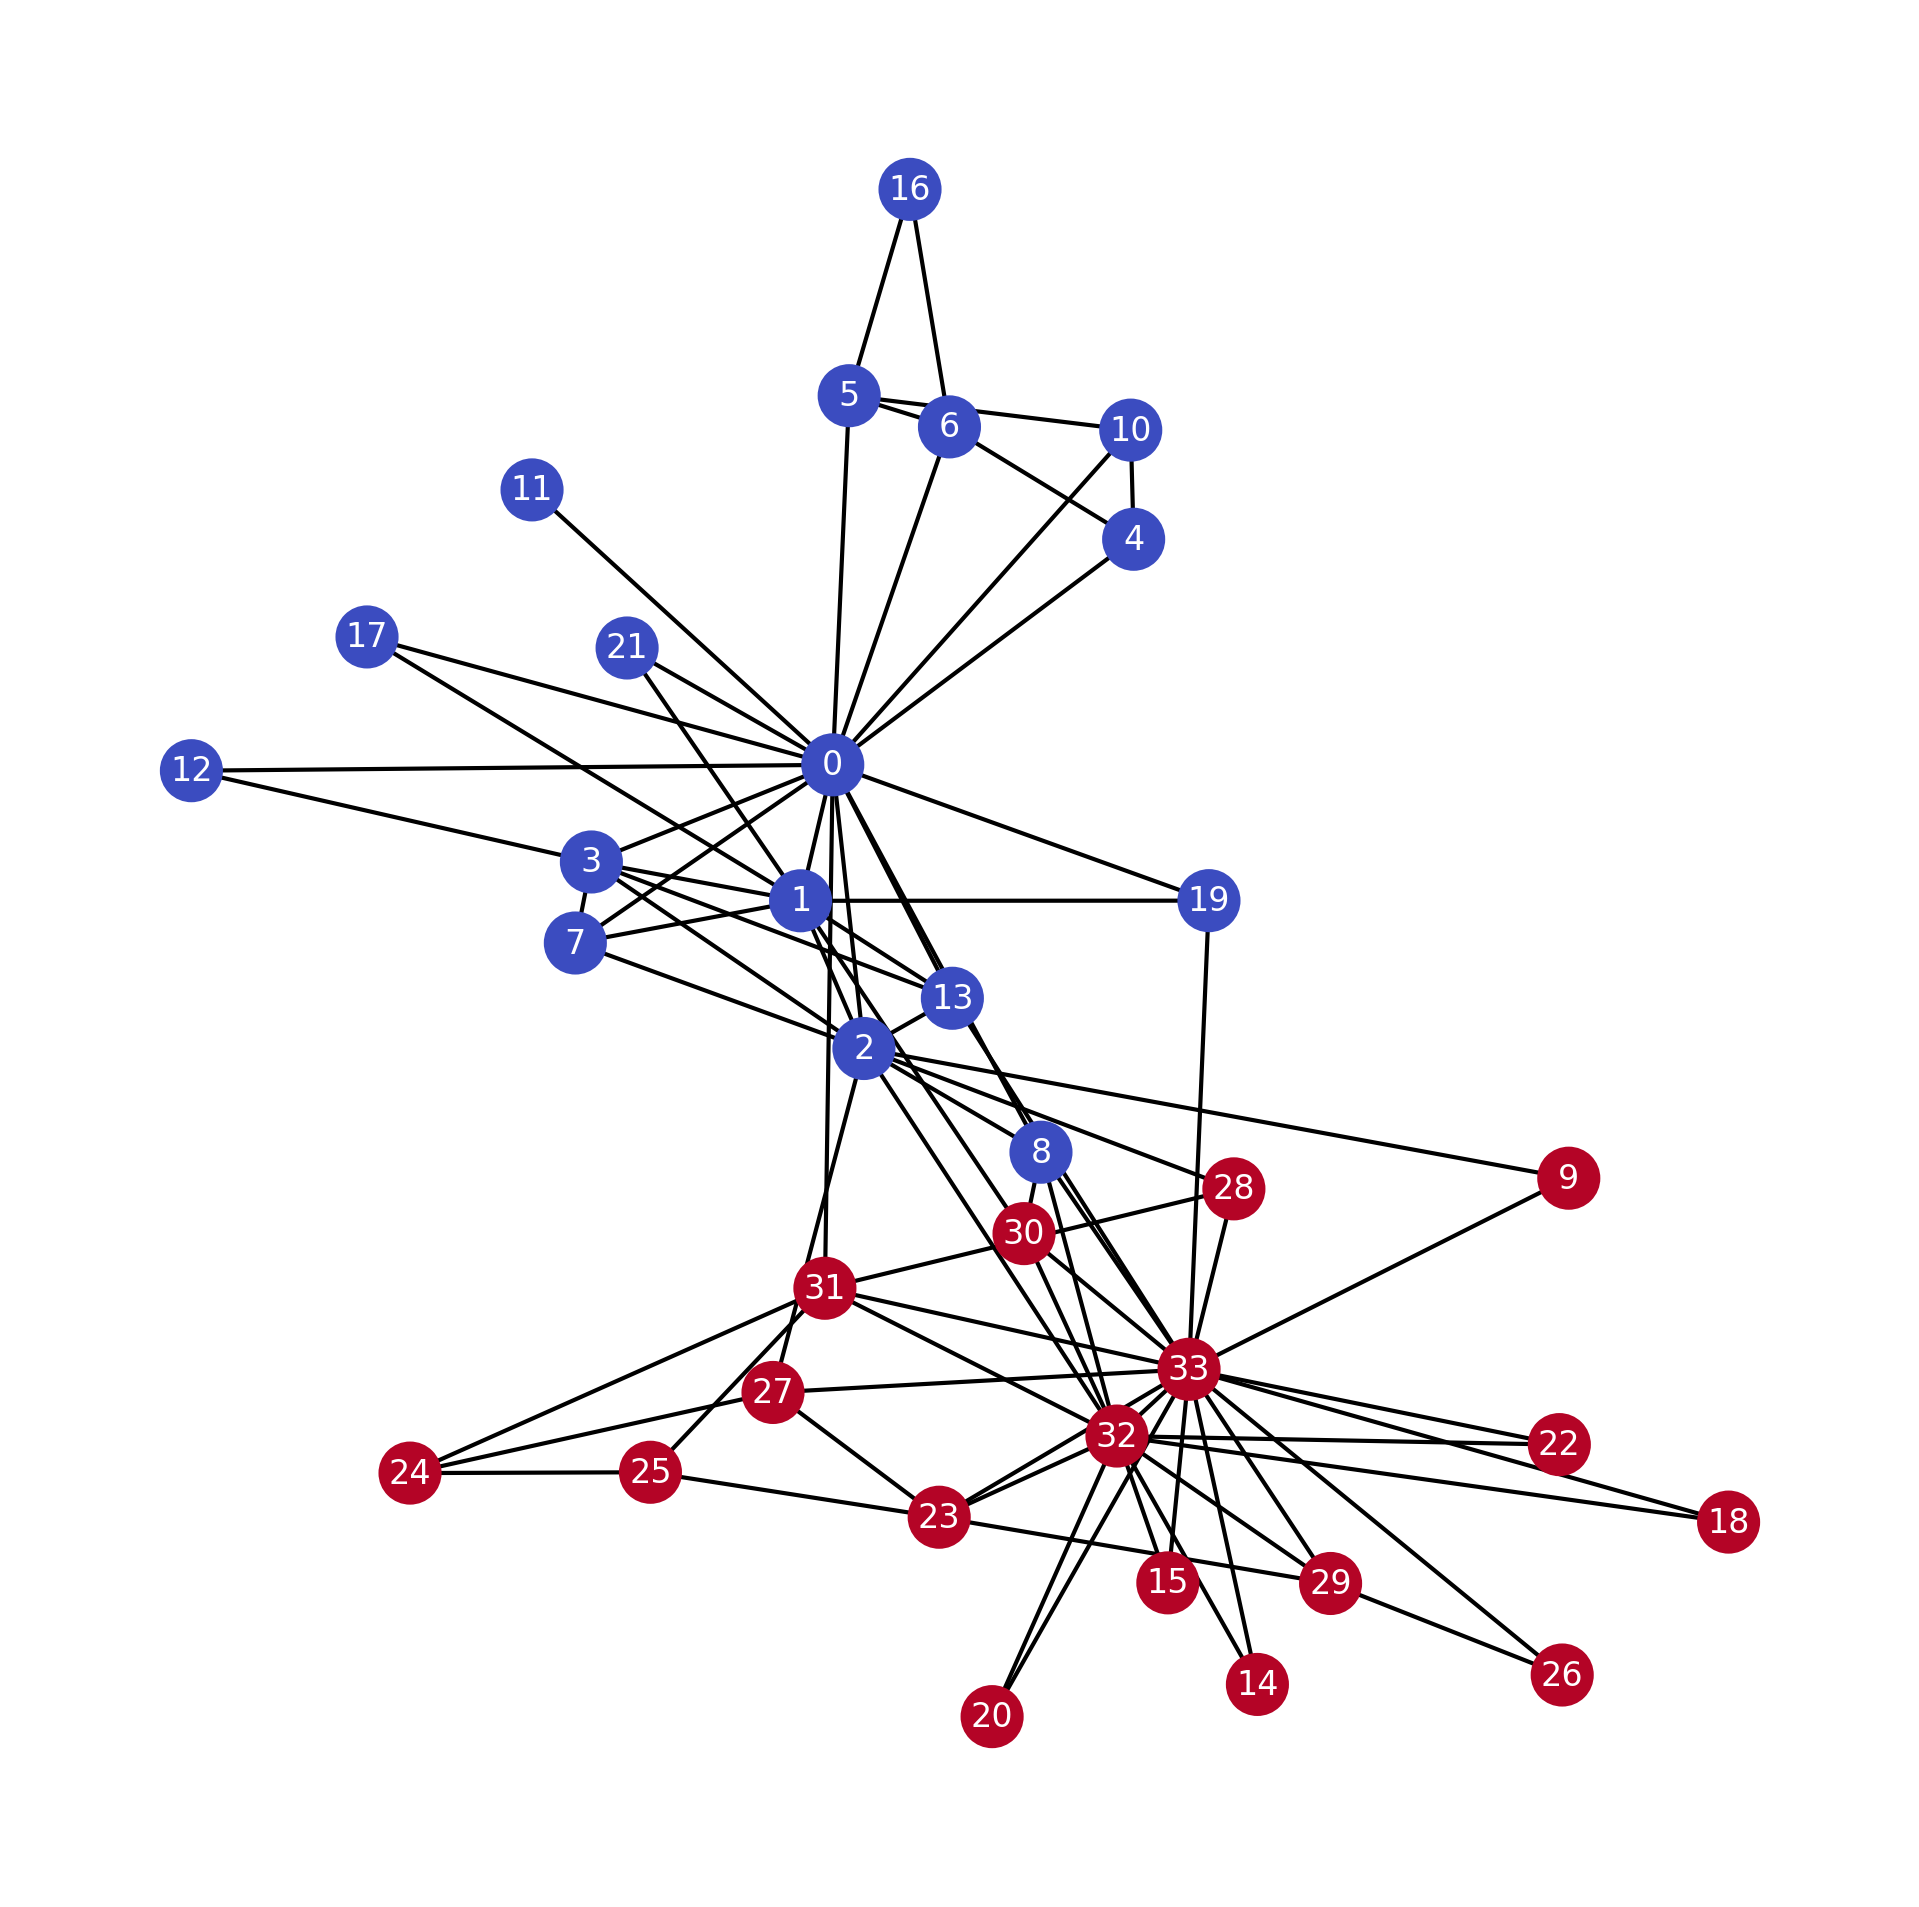

In [ ]:
plt.figure(figsize=(8,8), dpi=300)
plt.axis('off')
nx.draw_networkx(G,
pos=nx.spring_layout(G, seed=0),
                    node_color=labels,
                    node_size=200,
                    cmap='coolwarm',
                    font_size=8,
                    font_color='white'
                    )

This is a function that can generate a deep-walk , given a start node and length.

In [ ]:
def random_walk(start, length):
  walk = [str(start)] # starting node
  for i in range(length):
    neighbors = [node for node in G.neighbors(start)]
    next_node = np.random.choice(neighbors, 1)[0]
    walk.append(str(next_node))
    start = next_node
  return walk

In [ ]:
walks = []
for node in G.nodes:
  for i in range(80):
    walks.append(random_walk(node, 10))

At this point we have a list of walks, each walk is a list of nodes. For each node 80 walks, therefore making it 34*80 = 2720 walks. We can print 10 such random walks.

In [ ]:
n_walks = len(walks)
random_samples = np.random.choice(n_walks, 10)
[walks[i] for i in random_samples]

[['27', '24', '27', '33', '32', '33', '20', '33', '31', '0', '10'],
 ['14', '33', '9', '2', '8', '33', '13', '1', '17', '0', '10'],
 ['18', '32', '2', '32', '29', '32', '18', '33', '32', '20', '32'],
 ['15', '32', '30', '33', '20', '33', '15', '32', '30', '1', '17'],
 ['25', '31', '28', '31', '0', '6', '16', '5', '6', '5', '10'],
 ['10', '0', '4', '0', '5', '16', '6', '5', '6', '5', '6'],
 ['3', '7', '0', '19', '0', '21', '1', '21', '1', '19', '33'],
 ['26', '33', '20', '33', '13', '33', '32', '2', '28', '33', '9'],
 ['19', '0', '2', '0', '5', '16', '6', '16', '5', '0', '13'],
 ['31', '25', '24', '31', '25', '31', '28', '33', '8', '0', '19']]

The Word2vec algorithm can be trained on these 2720 walks , to generate a 100 dimensional vector for each node ( determined by __vector_size__ ).

In [ ]:
model = Word2Vec(walks,
                hs=1, # Hierarchical softmax
                sg=1, # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                seed=0)

model.train(walks, total_examples=model.corpus_count,
epochs=30, report_delay=1)

print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
  print(f' {similarity}')

Nodes that are the most similar to node 0:
 ('11', 0.7321215271949768)
 ('10', 0.7107431292533875)
 ('5', 0.6925910115242004)
 ('17', 0.6856442093849182)
 ('21', 0.682368814945221)
 ('4', 0.6600064635276794)
 ('16', 0.639663577079773)
 ('6', 0.6258345246315002)
 ('12', 0.6191818118095398)
 ('7', 0.591955840587616)


We can now extract the embeddings of the nodes and build a tsne visualization out of it

In [ ]:
node_embs = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

In [ ]:
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(node_embs)

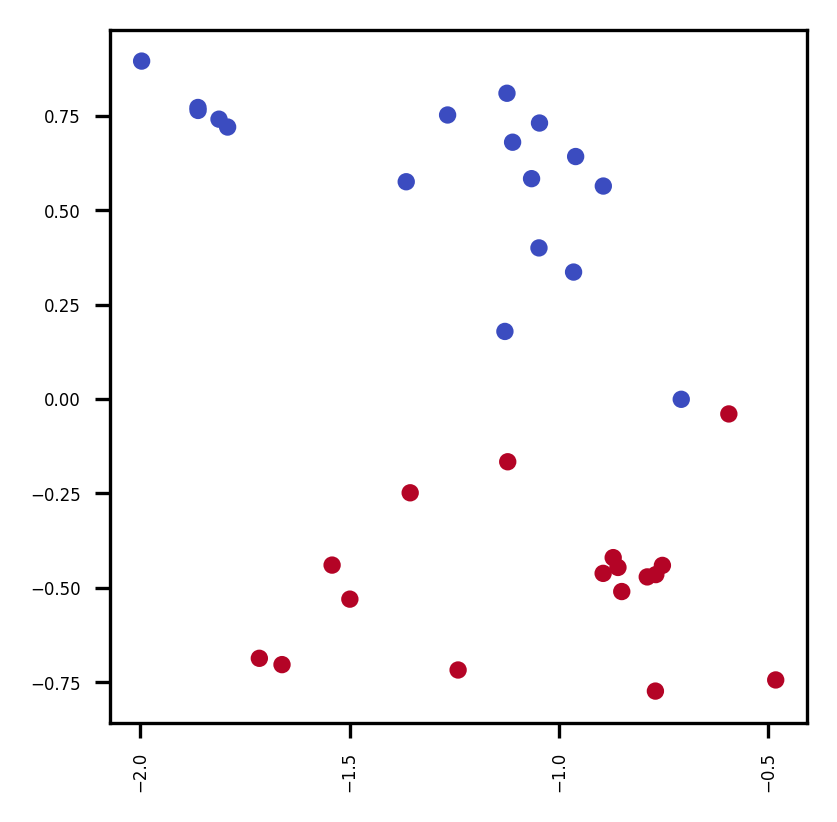

In [ ]:
plt.figure(figsize=(3, 3), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=10, c=labels, cmap="coolwarm")
plt.xticks(fontsize=4, rotation=90)
plt.yticks(fontsize=4)
plt.show()

### Building the Classifier

Now that we have node embeddings and a label for each node, in theory we can build a classifier for node classification. For splitting we chose 70% random nodes for training and the remaining for the test.   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
node_count = node_embs.shape[0]
train_nodes = np.random.choice(node_count,int(node_count*0.75))
test_nodes = [i for i in range(node_count) if i not in train_nodes]

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(node_embs[train_nodes],labels[train_nodes])

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = clf.predict(node_embs[test_nodes])
accuracy_score(y_pred, labels[test_nodes])

0.8823529411764706

Thus two useful applications of DeepWalk:
- Discovering similarities between nodes using embeddings and cosine similarity
(unsupervised learning)
- Using these embeddings as a dataset for a supervised task such as node classification